<a href="https://colab.research.google.com/github/veroonia/Calorie-Estimation/blob/main/Calorie_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import kagglehub
import os, glob, random
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

In [4]:
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.08G/1.08G [00:16<00:00, 71.2MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1


In [7]:
DATASET_PATH = path

def list_dirs(p):
    return sorted([d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))])

# Food-11 usually has: training / validation / evaluation
splits = [s for s in ["training", "validation", "evaluation"] if os.path.isdir(os.path.join(DATASET_PATH, s))]
print("Splits found:", splits)

# Choose a split to start with (training is best)
SPLIT = "training" if "training" in splits else splits[0]
split_dir = os.path.join(DATASET_PATH, SPLIT)

classes = list_dirs(split_dir)
print("Number of classes:", len(classes))
print("Class folders:", classes)

# Count images per class
counts = {}
for c in classes:
    c_dir = os.path.join(split_dir, c)
    imgs = glob.glob(os.path.join(c_dir, "*.jpg")) + glob.glob(os.path.join(c_dir, "*.png")) + glob.glob(os.path.join(c_dir, "*.jpeg"))
    counts[c] = len(imgs)

print(f"\nImage counts in '{SPLIT}':")
for c in classes:
    print(f"  {c}: {counts[c]}")

# Collect all image paths in this split (for later sampling/preview)
all_image_paths = glob.glob(os.path.join(split_dir, "*", "*.*"))
print("\nTotal images found in split:", len(all_image_paths))


Splits found: ['training', 'validation', 'evaluation']
Number of classes: 11
Class folders: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

Image counts in 'training':
  Bread: 994
  Dairy product: 429
  Dessert: 1500
  Egg: 986
  Fried food: 848
  Meat: 1325
  Noodles-Pasta: 440
  Rice: 280
  Seafood: 855
  Soup: 1500
  Vegetable-Fruit: 709

Total images found in split: 9866


A balanced visual inspection was performed to verify class diversity and image quality before applying image processing techniques.

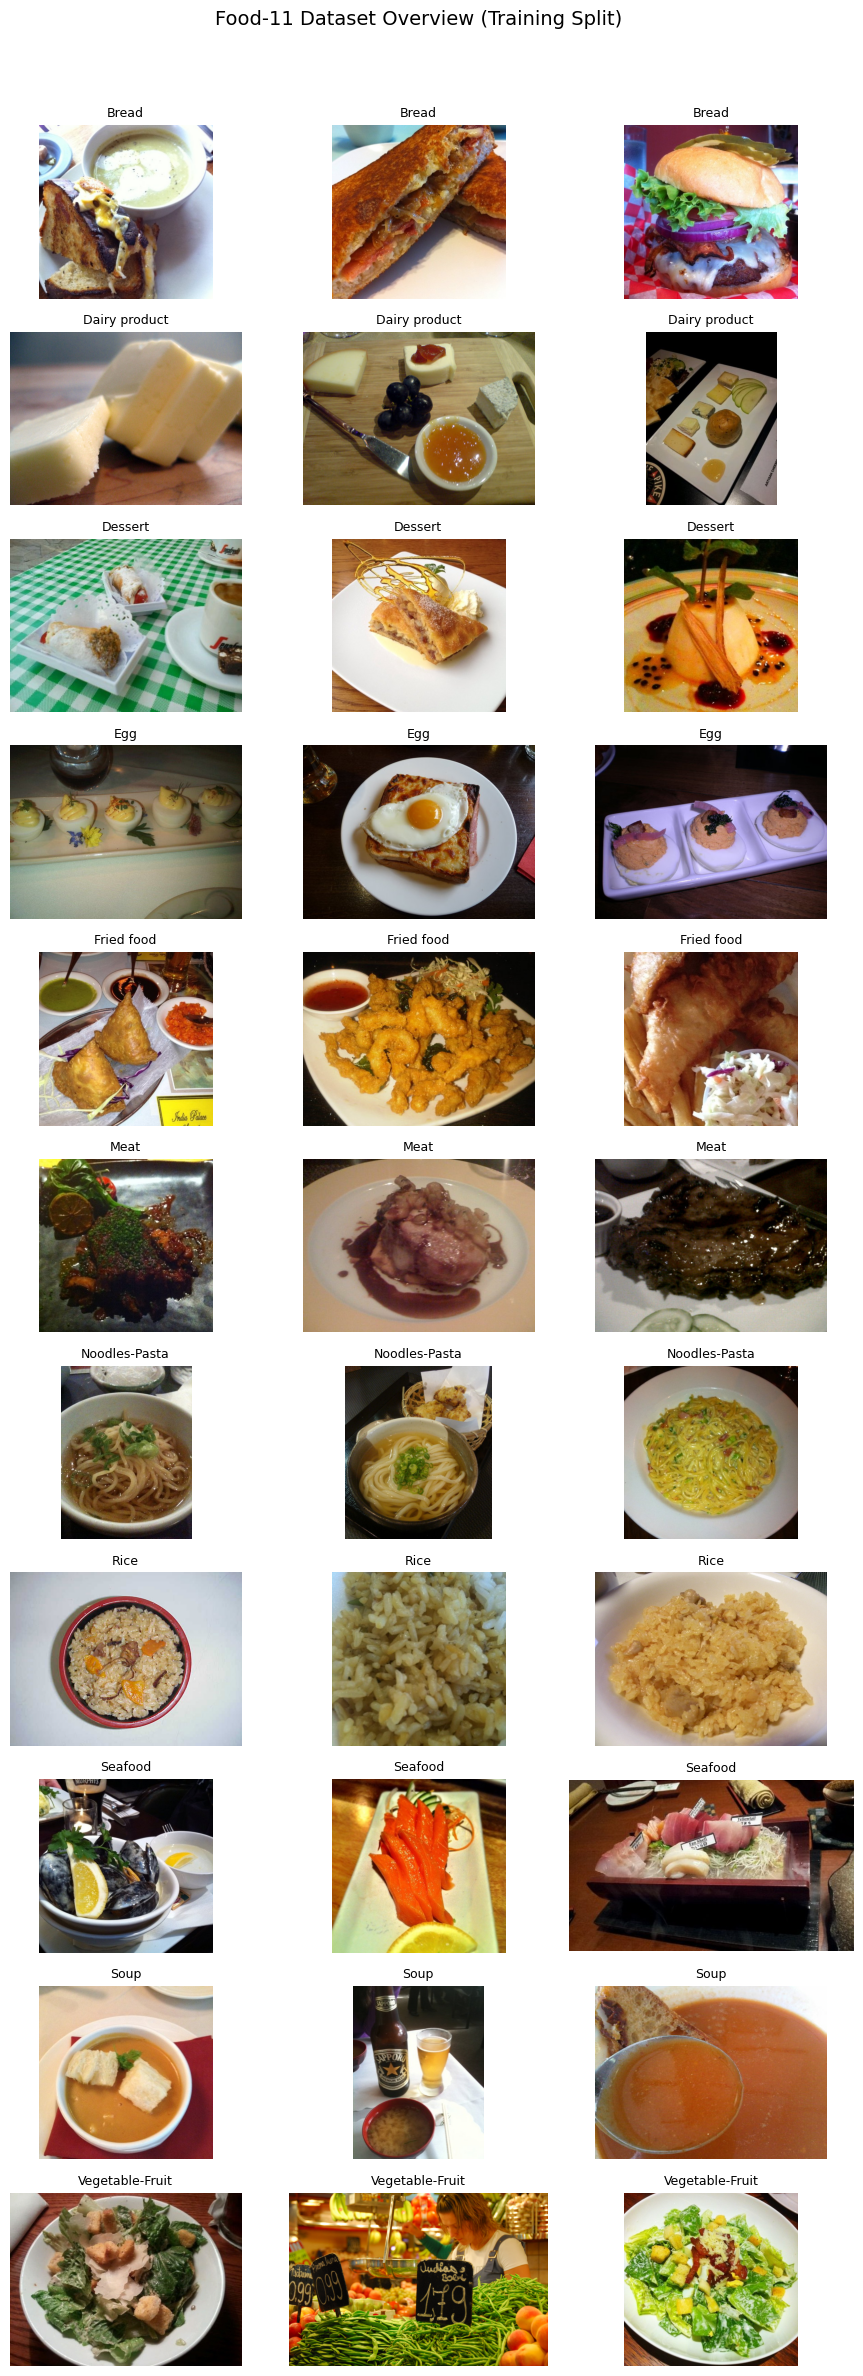

In [10]:
def show_balanced_grid(split_dir, classes, k_per_class=3):
    images = []
    titles = []

    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        img_paths = glob.glob(os.path.join(cls_dir, "*.*"))
        selected = random.sample(img_paths, k=min(k_per_class, len(img_paths)))

        for p in selected:
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            titles.append(cls)

    cols = k_per_class
    rows = len(classes)

    plt.figure(figsize=(cols * 3, rows * 2.2))
    idx = 1
    for img, title in zip(images, titles):
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(title, fontsize=9)
        plt.axis("off")
        idx += 1

    plt.suptitle("Food-11 Dataset Overview (Training Split)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_balanced_grid(split_dir, classes, k_per_class=3)

## Image Enhancement – Contrast Improvement using CLAHE

In this step, we apply image enhancement to improve local contrast and visibility of food textures.
Contrast Limited Adaptive Histogram Equalization (CLAHE) is applied to the luminance channel in LAB color space, which enhances contrast while preserving color information.

At this stage, enhancement is demonstrated on a small random subset of images for visual verification.
The enhancement operation will later be integrated into the full processing pipeline and applied dynamically during feature extraction and model training.


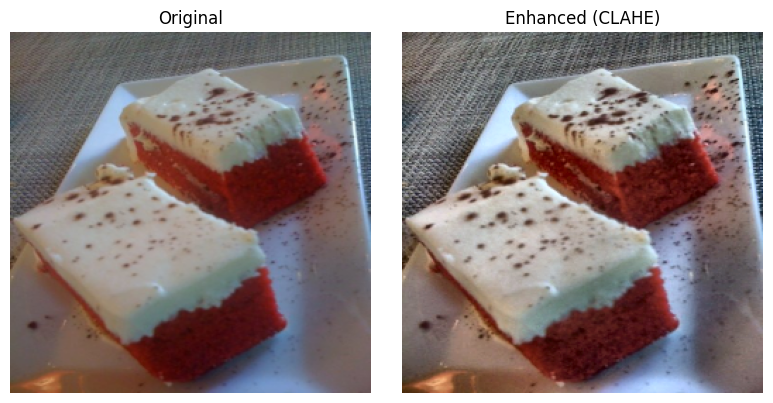

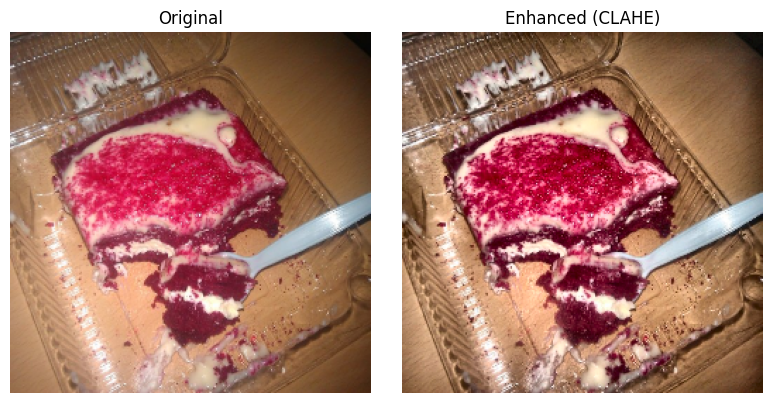

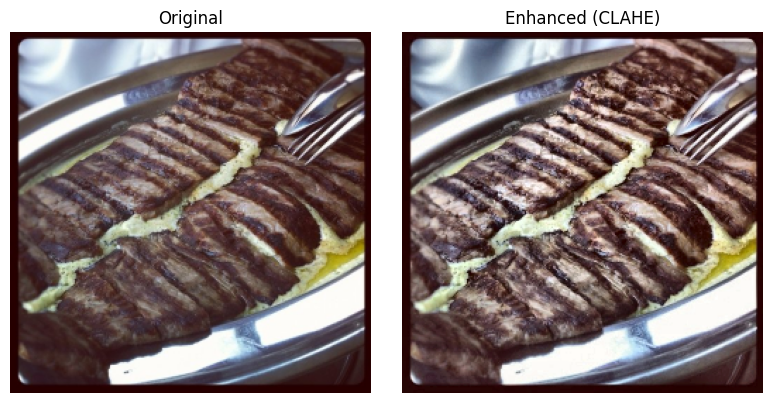

In [12]:
def enhance_clahe(bgr, clipLimit=2.0, tileGridSize=(8, 8)):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    L2 = clahe.apply(L)

    lab2 = cv2.merge([L2, A, B])
    out = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    return out

def show_before_after(img_path):
    bgr = cv2.imread(img_path)
    if bgr is None:
        print("Could not read:", img_path)
        return

    # keep visualization consistent
    bgr = cv2.resize(bgr, (256, 256))
    enhanced = enhance_clahe(bgr)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced (CLAHE)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Test on 3 random training images
sample_paths = random.sample(all_image_paths, k=3)
for p in sample_paths:
    show_before_after(p)
